In [30]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import numpy as np
import datetime as dt

path = kagglehub.dataset_download("sachinkanchan92/reddit-top-posts-50-subreddit-analysis-2011-2024")
print(f'Path to dataset files: {path}')
file_list = [f for f in os.listdir(path) if f.endswith('.csv') and f != '50_subreddits_list.csv']

Path to dataset files: /root/.cache/kagglehub/datasets/sachinkanchan92/reddit-top-posts-50-subreddit-analysis-2011-2024/versions/3


In [31]:
subreddit_stats_list = []
all_data = pd.DataFrame()
for file in file_list:
  df = pd.read_csv(os.path.join(path, file))
  # drop null column
  df.drop(columns = ['crosspost_subreddits', 'body', 'id', 'permalink', 'url', 'domain'], inplace = True)
  # Convert created_utc to datetime
  if 'created_utc' in df.columns:
        df['created_utc'] = pd.to_datetime(df['created_utc'], errors='coerce')  # Convert to datetime, handling errors
  else:
      print("Column 'created_utc' not found in this dataset.")

  # Encode dummy variables
  df['is_nsfw'] = df['is_nsfw'].replace(True, 1)
  df['is_nsfw'] = df['is_nsfw'].replace(False, 0)
  df['is_bot'] = df['is_bot'].replace(True, 1)
  df['is_bot'] = df['is_bot'].replace(False, 0)
  df['is_megathread'] = df['is_megathread'].replace(True, 1)
  df['is_megathread'] = df['is_megathread'].replace(False, 0)

  # Fill null value by mode
  pd.set_option('future.no_silent_downcasting', True)
  df['is_nsfw'] = df['is_nsfw'].fillna(df['is_nsfw'].mode()[0])
  df['is_bot'] = df['is_bot'].fillna(df['is_bot'].mode()[0])
  df['is_megathread'] = df['is_megathread'].fillna(df['is_megathread'].mode()[0])

  df['title'] = df['title'].str.replace(r'[^\w\s]', '', regex=True)
  df.drop_duplicates(inplace = True)


  # Calculate averages for the subreddit
  avg_score = df['score'].mean() if 'score' in df.columns else 0
  avg_upvote_ratio = df['upvote_ratio'].mean() if 'upvote_ratio' in df.columns else 0
  avg_comments = df['num_comments'].mean() if 'num_comments' in df.columns else 0
  avg_num_crossposts = df['num_crossposts'].mean() if 'num_crossposts' in df.columns else 0
  nsfw_ratio = df['is_nsfw'].mean() if 'is_nsfw' in df.columns else 0
  num_megathreads = df['is_megathread'].sum() if 'is_megathread' in df.columns else 0
  subscribers = df['subscribers'].iloc[0] if 'subscribers' in df.columns else 0

  # Append the statistics to the list
  subreddit_stats_list.append({
      'subreddit': str(file),
      'avg_score': avg_score,
      'avg_upvote_ratio': avg_upvote_ratio,
      'avg_comments': avg_comments,
      'avg_num_crossposts': avg_num_crossposts,
      'avg_nsfw_ratio': nsfw_ratio,
      'avg_num_megathreads': num_megathreads,
      'avg_subscribers': subscribers
  })

  # Concatenate all cleaned csv files together in all_data
  df['subreddit'] = file
  all_data = pd.concat([all_data, df], ignore_index=True)

subreddit_stats = pd.DataFrame(subreddit_stats_list)

In [32]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
numerical_stats = subreddit_stats.drop(columns = 'subreddit')
print(numerical_stats.columns)
scaled_subreddit_stats = scaler.fit_transform(numerical_stats)
scaled_subreddit_df = pd.DataFrame(scaled_subreddit_stats, columns=numerical_stats.columns, index=subreddit_stats.index)
scaled_subreddit_stats = pd.concat([subreddit_stats['subreddit'], scaled_subreddit_df], axis=1)

Index(['avg_score', 'avg_upvote_ratio', 'avg_comments', 'avg_num_crossposts',
       'avg_nsfw_ratio', 'avg_num_megathreads', 'avg_subscribers'],
      dtype='object')


# Clustering

In [33]:
scaled_subreddit_stats.head()

,subreddit,avg_score,avg_upvote_ratio,avg_comments,avg_num_crossposts,avg_nsfw_ratio,avg_num_megathreads,avg_subscribers
0,iama.csv,-0.689728,-3.008627,0.413454,-0.687194,0.153387,-0.309326,-0.218948
1,lifeprotips.csv,0.076327,-0.788209,-0.150690,-0.279481,-0.299680,-0.309326,-0.204670
2,relationship_advice.csv,-0.890516,1.035162,-0.160949,-0.763428,-0.018994,-0.309326,-1.091319
3,art.csv,-0.642694,0.805386,-0.637886,-0.324868,1.539384,-0.309326,-0.232103
4,getmotivated.csv,-0.411474,-0.107243,-0.539681,-0.061687,-0.452336,-0.309326,-0.186467


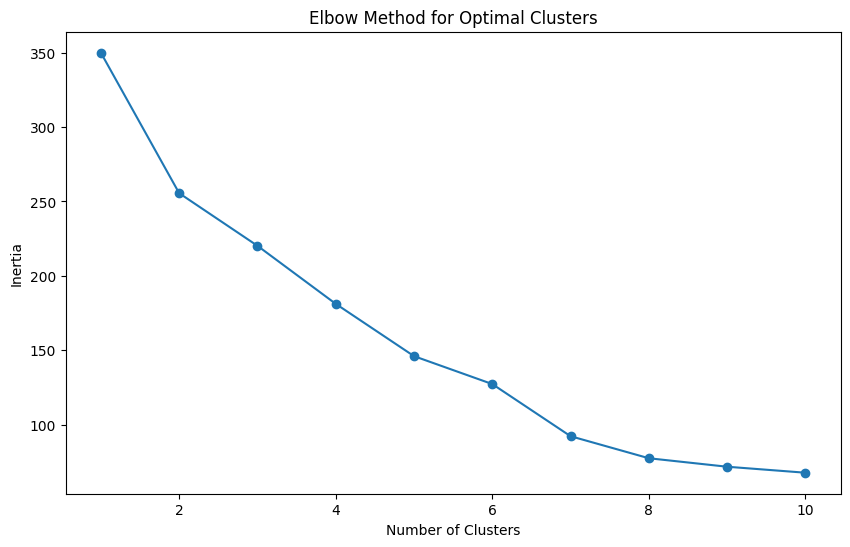

In [34]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Drop non-numerical columns
numerical_stats = scaled_subreddit_stats.drop(columns=['subreddit'], errors='ignore')

# Elbow Method to find the optimal number of clusters
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(numerical_stats)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(K, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Clusters')
plt.show()

In [35]:
# Apply K-Means with the chosen number of clusters
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
numerical_stats['cluster'] = kmeans.fit_predict(numerical_stats)

# Add cluster labels to the original subreddit stats
clustered_stats = scaled_subreddit_stats.copy()
clustered_stats['cluster'] = numerical_stats['cluster']

print(clustered_stats.head())

                 subreddit  avg_score  avg_upvote_ratio  avg_comments  \
0                 iama.csv  -0.689728         -3.008627      0.413454   
1          lifeprotips.csv   0.076327         -0.788209     -0.150690   
2  relationship_advice.csv  -0.890516          1.035162     -0.160949   
3                  art.csv  -0.642694          0.805386     -0.637886   
4         getmotivated.csv  -0.411474         -0.107243     -0.539681   

   avg_num_crossposts  avg_nsfw_ratio  avg_num_megathreads  avg_subscribers  \
0           -0.687194        0.153387            -0.309326        -0.218948   
1           -0.279481       -0.299680            -0.309326        -0.204670   
2           -0.763428       -0.018994            -0.309326        -1.091319   
3           -0.324868        1.539384            -0.309326        -0.232103   
4           -0.061687       -0.452336            -0.309326        -0.186467   

   cluster  
0        0  
1        0  
2        2  
3        2  
4        2  


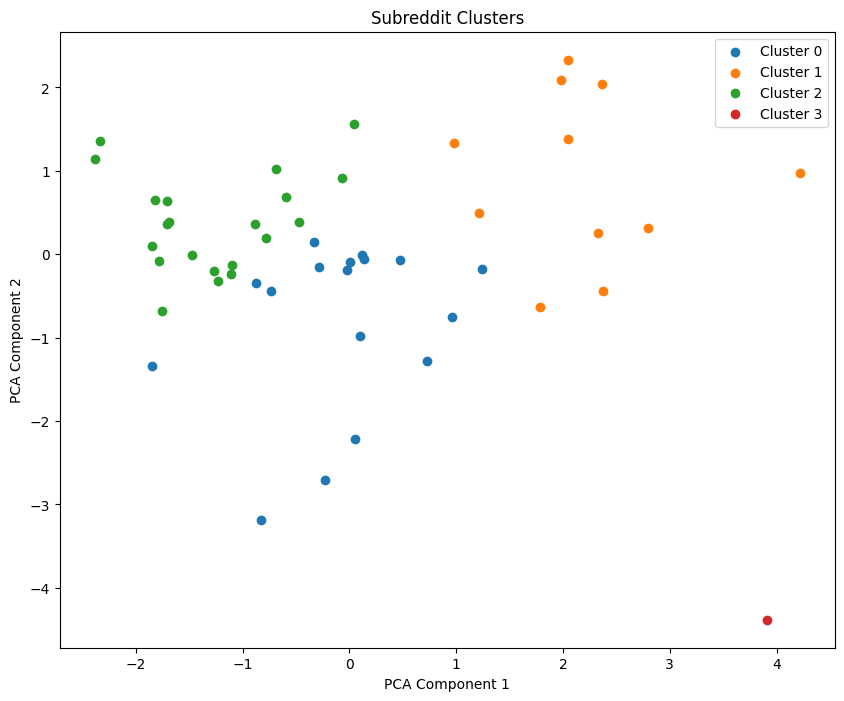

In [36]:
from sklearn.decomposition import PCA

# Reduce dimensions to 2 for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(numerical_stats.drop(columns='cluster'))
clustered_stats['pca1'] = reduced_data[:, 0]
clustered_stats['pca2'] = reduced_data[:, 1]

plt.figure(figsize=(10, 8))
for cluster in range(optimal_k):
    cluster_data = clustered_stats[clustered_stats['cluster'] == cluster]
    plt.scatter(cluster_data['pca1'], cluster_data['pca2'], label=f'Cluster {cluster}')

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Subreddit Clusters')
plt.legend()
plt.show()

In [37]:
for cluster in range(optimal_k):
    subreddits = clustered_stats[clustered_stats['cluster'] == cluster]['subreddit']
    print(f"Cluster {cluster} contains {len(subreddits)} subreddits:\n{subreddits.tolist()}\n")

Cluster 0 contains 17 subreddits:
['iama.csv', 'lifeprotips.csv', 'movies.csv', 'music.csv', 'technology.csv', 'jokes.csv', 'television.csv', 'askscience.csv', 'dataisbeautiful.csv', 'sports.csv', 'science.csv', 'showerthoughts.csv', 'nottheonion.csv', 'tifu.csv', 'books.csv', 'futurology.csv', 'videos.csv']

Cluster 1 contains 11 subreddits:
['pics.csv', 'interestingasfuck.csv', 'gifs.csv', 'worldnews.csv', 'gaming.csv', 'memes.csv', 'todayilearned.csv', 'funny.csv', 'news.csv', 'mildlyinteresting.csv', 'aww.csv']

Cluster 2 contains 21 subreddits:
['relationship_advice.csv', 'art.csv', 'getmotivated.csv', 'travel.csv', 'documentaries.csv', 'nostupidquestions.csv', 'food.csv', 'oldschoolcool.csv', 'listentothis.csv', 'writingprompts.csv', 'earthporn.csv', 'space.csv', 'anime.csv', 'wholesomememes.csv', 'personalfinance.csv', 'internetisbeautiful.csv', 'diy.csv', 'upliftingnews.csv', 'history.csv', 'creepy.csv', 'explainlikeimfive.csv']

Cluster 3 contains 1 subreddits:
['askreddit.csv

In [38]:
cluster_summary = clustered_stats.drop(columns=['subreddit'], errors='ignore').groupby('cluster').mean()
print(cluster_summary)

         avg_score  avg_upvote_ratio  avg_comments  avg_num_crossposts  \
cluster                                                                  
0        -0.213014         -0.860736      0.009196           -0.304759   
1         1.568291          0.059311      0.291782            1.484041   
2        -0.677577          0.710246     -0.457599           -0.544070   
3         0.599137         -0.935070      6.243656            0.281926   

         avg_nsfw_ratio  avg_num_megathreads  avg_subscribers      pca1  \
cluster                                                                   
0              0.258039             0.210549         0.032143 -0.079235   
1             -0.372677            -0.242372         0.903548  2.192271   
2             -0.088651            -0.098900        -0.610117 -1.270274   
3              1.574449             1.163654         2.327008  3.907769   

             pca2  
cluster            
0       -0.814069  
1        0.922666  
2        0.384392  
3   

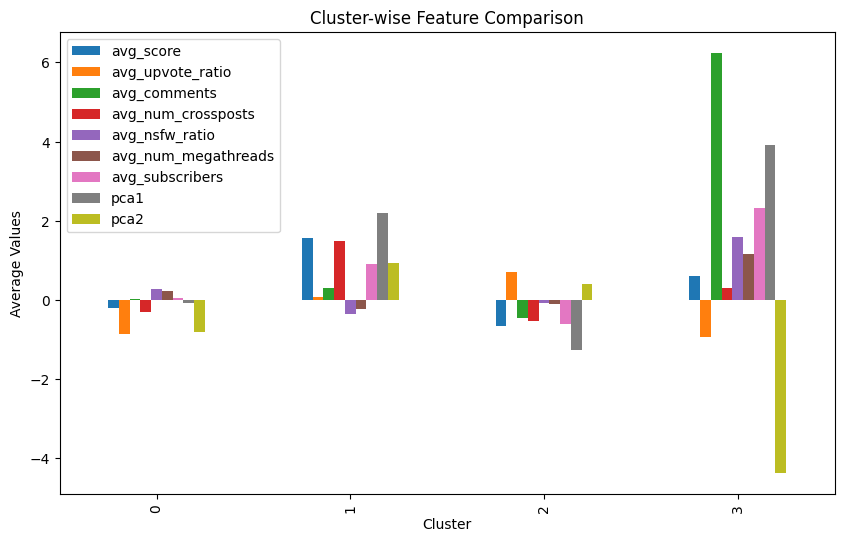

In [39]:
cluster_summary.plot(kind='bar', figsize=(10, 6))
plt.title('Cluster-wise Feature Comparison')
plt.xlabel('Cluster')
plt.ylabel('Average Values')
plt.show()

# Time-series

In [40]:
all_data.head()

,title,score,upvote_ratio,num_comments,created_utc,subreddit,subscribers,num_awards,num_crossposts,post_type,is_nsfw,is_bot,is_megathread
0,I am Barack Obama President of the United Stat...,216187,0.68,22808,2012-08-30 01:31:36,iama.csv,22547664,0,19,text,0,0,0
1,Protect Net Neutrality Save the Internet,201665,0.88,2709,2017-11-22 11:03:26,iama.csv,22547664,0,15,link,0,0,0
2,AMA Request Victoria exAMA mod,126770,0.81,2775,2015-07-03 23:06:00,iama.csv,22547664,0,2,text,0,0,0
3,FCC just voted to kill Net Neutrality Now we w...,121804,0.79,2587,2017-12-14 23:42:50,iama.csv,22547664,0,2,text,0,0,0
4,Im American citizen undecided voter loving hus...,116917,0.87,16619,2016-10-14 06:51:33,iama.csv,22547664,0,1,text,0,0,0


In [41]:
# Select only numeric columns and datetime column
numeric_data = all_data.select_dtypes(include=['number']).copy()
numeric_data['created_utc'] = all_data['created_utc']

numeric_data

,score,upvote_ratio,num_comments,subscribers,num_awards,num_crossposts,created_utc
0,216187,0.68,22808,22547664,0,19,2012-08-30 01:31:36
1,201665,0.88,2709,22547664,0,15,2017-11-22 11:03:26
2,126770,0.81,2775,22547664,0,2,2015-07-03 23:06:00
3,121804,0.79,2587,22547664,0,2,2017-12-14 23:42:50
4,116917,0.87,16619,22547664,0,1,2016-10-14 06:51:33
...,...,...,...,...,...,...,...
49261,8296,0.92,1418,22924375,0,0,2024-03-17 23:14:44
49262,7973,0.90,2706,22924375,0,0,2024-03-20 20:39:04
49263,7393,0.90,1461,22924375,0,2,2023-08-23 18:36:07
49264,7167,0.91,1257,22924375,0,0,2023-11-14 20:30:32


In [42]:
# Resample numeric data by month and calculate the mean
time_series_data = numeric_data.resample('ME', on='created_utc').mean()
time_series_data.reset_index(inplace=True)

time_series_data

,created_utc,score,upvote_ratio,num_comments,subscribers,num_awards,num_crossposts
0,2011-09-30,1218.000000,0.890000,226.000000,1.799967e+07,0.0,0.000000
1,2011-10-31,NaN,NaN,NaN,NaN,NaN,NaN
2,2011-11-30,NaN,NaN,NaN,NaN,NaN,NaN
3,2011-12-31,NaN,NaN,NaN,NaN,NaN,NaN
4,2012-01-31,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
152,2024-05-31,27310.216867,0.914096,1993.060241,2.162201e+07,0.0,4.963855
153,2024-06-30,35094.102941,0.910882,2215.588235,2.205786e+07,0.0,5.735294
154,2024-07-31,46892.154762,0.900119,3294.416667,2.156658e+07,0.0,11.095238
155,2024-08-31,40244.165517,0.907793,2086.351724,2.226081e+07,0.0,7.613793


In [43]:
# Check where NaN values occur
missing_data_summary = time_series_data.isnull().sum()
print(missing_data_summary)

print("Rows with missing values:", time_series_data.isnull().any(axis=1).sum())

created_utc        0
score             23
upvote_ratio      23
num_comments      23
subscribers       23
num_awards        23
num_crossposts    23
dtype: int64
Rows with missing values: 23


In [44]:
# Forward-fill missing values to maintain trends
time_series_data.ffill(inplace=True)
time_series_data

,created_utc,score,upvote_ratio,num_comments,subscribers,num_awards,num_crossposts
0,2011-09-30,1218.000000,0.890000,226.000000,1.799967e+07,0.0,0.000000
1,2011-10-31,1218.000000,0.890000,226.000000,1.799967e+07,0.0,0.000000
2,2011-11-30,1218.000000,0.890000,226.000000,1.799967e+07,0.0,0.000000
3,2011-12-31,1218.000000,0.890000,226.000000,1.799967e+07,0.0,0.000000
4,2012-01-31,1218.000000,0.890000,226.000000,1.799967e+07,0.0,0.000000
...,...,...,...,...,...,...,...
152,2024-05-31,27310.216867,0.914096,1993.060241,2.162201e+07,0.0,4.963855
153,2024-06-30,35094.102941,0.910882,2215.588235,2.205786e+07,0.0,5.735294
154,2024-07-31,46892.154762,0.900119,3294.416667,2.156658e+07,0.0,11.095238
155,2024-08-31,40244.165517,0.907793,2086.351724,2.226081e+07,0.0,7.613793


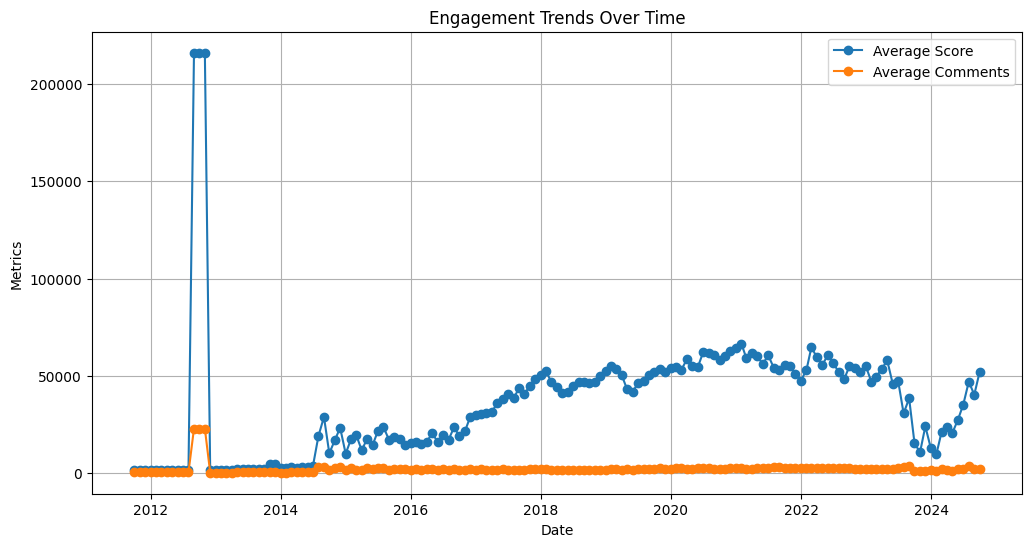

In [45]:
# Plot average score and comments over time
plt.figure(figsize=(12, 6))
plt.plot(time_series_data['created_utc'], time_series_data['score'], label='Average Score', marker='o')
plt.plot(time_series_data['created_utc'], time_series_data['num_comments'], label='Average Comments', marker='o')
plt.title('Engagement Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Metrics')
plt.legend()
plt.grid()
plt.show()

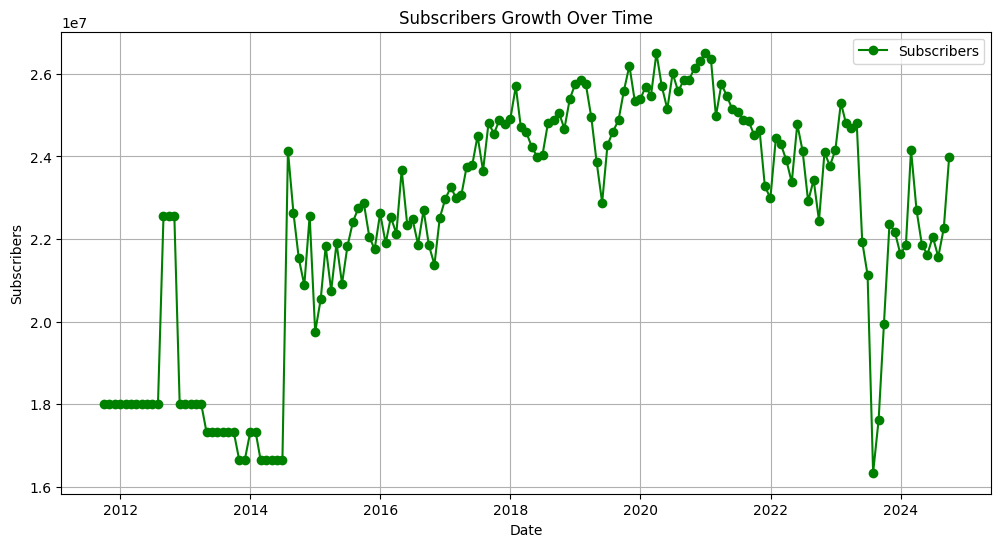

In [46]:
# Plot subscribers over time
plt.figure(figsize=(12, 6))
plt.plot(time_series_data['created_utc'], time_series_data['subscribers'], label='Subscribers', marker='o', color='green')
plt.title('Subscribers Growth Over Time')
plt.xlabel('Date')
plt.ylabel('Subscribers')
plt.legend()
plt.grid()
plt.show()

In [47]:
# Filter data for 2012
spike_data = numeric_data[(numeric_data['created_utc'] >= '2012-01-01') & (numeric_data['created_utc'] < '2013-01-01')]
print(spike_data.sort_values('score', ascending=False).head())

        score  upvote_ratio  num_comments  subscribers  num_awards  \
0      216187          0.68         22808     22547664           0   
19431    1322          0.97            70     17999667           0   

       num_crossposts         created_utc  
0                  19 2012-08-30 01:31:36  
19431               0 2012-11-16 15:47:37  


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpe6zjm8lq/1qtw6un8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpe6zjm8lq/bfi4r655.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98734', 'data', 'file=/tmp/tmpe6zjm8lq/1qtw6un8.json', 'init=/tmp/tmpe6zjm8lq/bfi4r655.json', 'output', 'file=/tmp/tmpe6zjm8lq/prophet_modelxu2o5c_x/prophet_model-20241207000847.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:08:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:08:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


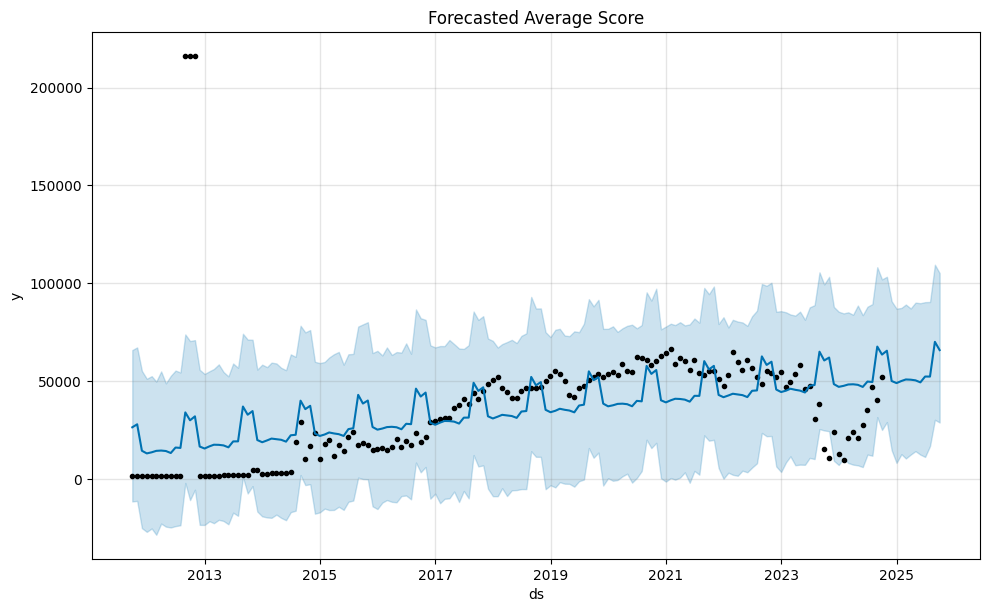

In [48]:
from prophet import Prophet

# Prepare data for Prophet
prophet_data = time_series_data[['created_utc', 'score']].rename(columns={'created_utc': 'ds', 'score': 'y'})

# Initialize and fit the Prophet model including yearly seasonality
model = Prophet(yearly_seasonality=True)
model.fit(prophet_data)

# Create future dates for prediction
future_dates = model.make_future_dataframe(periods=12, freq='ME')  # Next 12 months
forecast = model.predict(future_dates)

# Plot the forecast
fig = model.plot(forecast)
plt.title('Forecasted Average Score')
plt.show()

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpe6zjm8lq/r60swhwp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpe6zjm8lq/k88ltapr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88214', 'data', 'file=/tmp/tmpe6zjm8lq/r60swhwp.json', 'init=/tmp/tmpe6zjm8lq/k88ltapr.json', 'output', 'file=/tmp/tmpe6zjm8lq/prophet_model_b9acqha/prophet_model-20241207000848.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:08:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:08:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


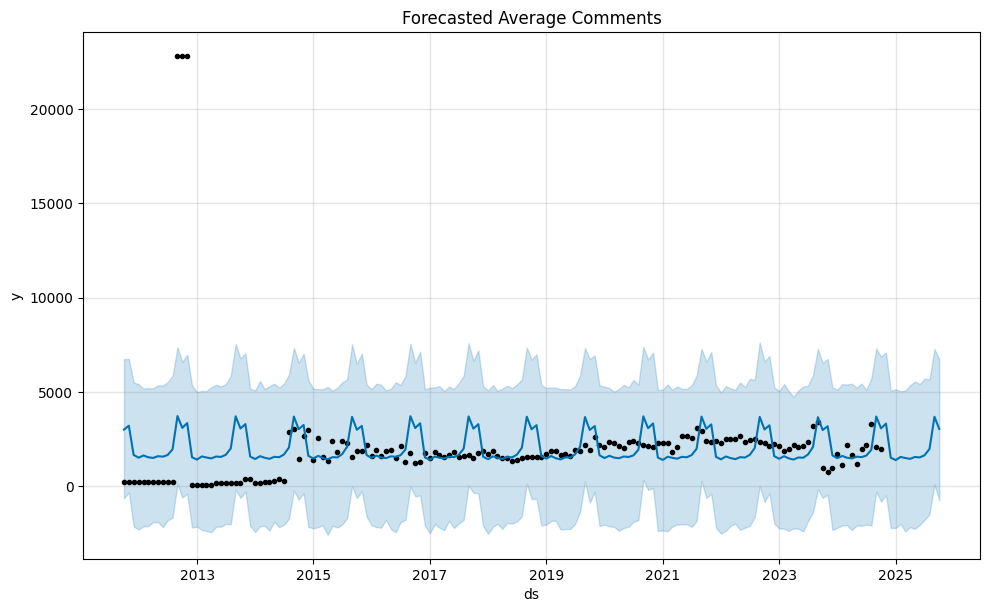

In [49]:
prophet_data_comments = time_series_data[['created_utc', 'num_comments']].rename(columns={'created_utc': 'ds', 'num_comments': 'y'})

model_comments = Prophet(yearly_seasonality=True)
model_comments.fit(prophet_data_comments)

future_dates_comments = model_comments.make_future_dataframe(periods=12, freq='ME')
forecast_comments = model_comments.predict(future_dates_comments)

fig = model_comments.plot(forecast_comments)
plt.title('Forecasted Average Comments')
plt.show()

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpe6zjm8lq/1fok4nv3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpe6zjm8lq/6mvai5i2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17852', 'data', 'file=/tmp/tmpe6zjm8lq/1fok4nv3.json', 'init=/tmp/tmpe6zjm8lq/6mvai5i2.json', 'output', 'file=/tmp/tmpe6zjm8lq/prophet_modelmm7hluu4/prophet_model-20241207000849.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:08:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:08:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


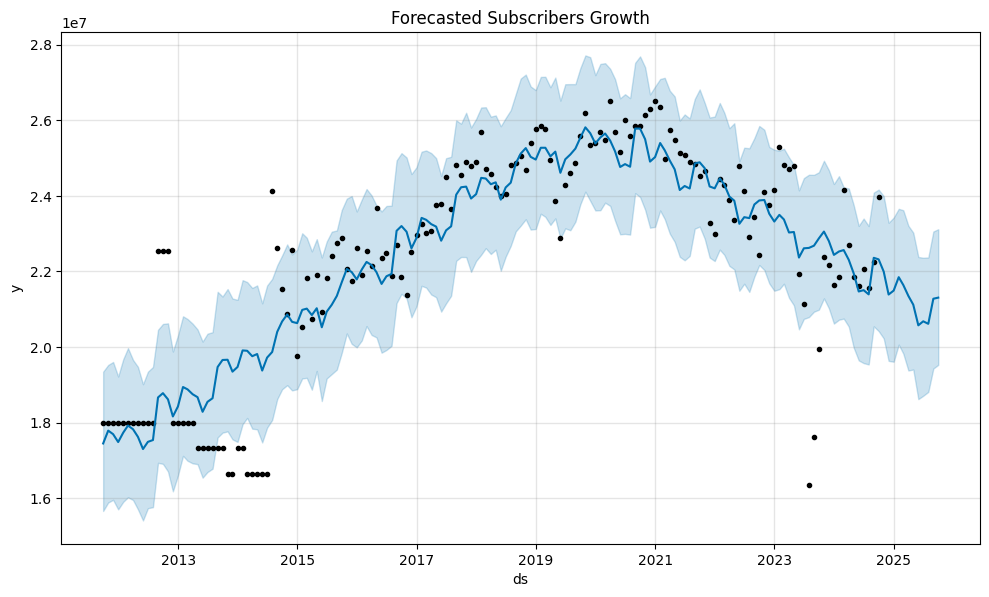

In [50]:
prophet_data_subscribers = time_series_data[['created_utc', 'subscribers']].rename(columns={'created_utc': 'ds', 'subscribers': 'y'})

model_subscribers = Prophet(yearly_seasonality=True)
model_subscribers.fit(prophet_data_subscribers)

future_dates_subscribers = model_subscribers.make_future_dataframe(periods=12, freq='ME')
forecast_subscribers = model_subscribers.predict(future_dates_subscribers)

fig = model_subscribers.plot(forecast_subscribers)
plt.title('Forecasted Subscribers Growth')
plt.show()